# Tequila Tutorial:

## Single-qubit classifier with data re-uploading

This tutorial shows:
- How to construct a fidelity cost function for an optimization problem
- How to construct a quantum classifier with one qubit

Based on [Data re-uploading for a universal quantum classifier](https://quantum-journal.org/papers/q-2020-02-06-226/), A. Pérez-Salinas, A. Cervera-Lierta, E. Gil-Fuster, and J. I. Latorre, *Quantum **4**, 226 (2020)*.

In [1]:
import tequila as tq
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import time

### Introduction

Single-qubit operations are just rotations on the Bloch sphere. A collection of single-qubit rotations can be reduced to a single one by combining their angles: you can always move from one point to another on the Bloch sphere with a single operation. 

Because of this property, a single-qubit classifier with simple parameterized rotations can not treat complex data. Even if it succeeds to classify one data point, it will probably misclassify the others since rotational angles have been only adapted to one particular point. To circumvent this limitation one can introduce the data points into these angles, so each rotation will be data point-dependent. This methodology is called data re-uploading and it can be shown that a single-qubit classifier can be universal using this technique.

The strategy to train this single-qubit classifier is the following. Given a problem with 𝑛n classes, we choose 𝑛n vectors on the Bloch sphere. Then, we train the classifier by constructing a cost function that adds penalties if the final state of the classifier is far from the target state that corresponds to its class.

The single-qubit classifier circuit is divided into layers. Each layer comprises single-qubit rotations that encode a data training point and parameters to be optimized. $$ L\left(\vec{x};\vec{\theta}_{i}\right) = U\left(\vec{x}\right)U\left(\vec{\theta}_{i}\right) $$
By considering more layers, the final state of the classifier will have a richer structure in terms of the data point $\vec{x}$.

$$ \mathcal{U}_{class}\left(\vec{x};\vec{\theta}_{1},\vec{\theta}_{2},...,\vec{\theta}_{l}\right) = L\left(\vec{x};\vec{\theta}_{1}\right)L\left(\vec{x};\vec{\theta}_{2}\right)\cdots L\left(\vec{x};\vec{\theta}_{l}\right)$$

We will run a $\mathcal{U}_{class}$ for each training point $\vec{x}$, but the parameters $\vec{\theta}$ are the same. These are the variables to be optimized classically through the cost function.

### Model

Let's define the model that we would like to classify. Let's start with a simple model with two classes: a circle of radius $r =\sqrt{2/\pi}$ centered at (0,0). Data points will be distributed in a square of length 2 centered at (0,0). The particular choice of the circle radius implies that a random classification will have a $\sim 50$% accuracy.

`circle` function will have two parts:
- `random = True`: generate and label random points according to their position inside or outside the circle (used for training)
- `random = False`: computes the label of a given point `x_input` (used for testing)

In [2]:
np.random.seed(42)

def circle(samples = False, random = True, x_input = False, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):   
    """
    Args:
        samples (int): number of samples to generate
        random = True: generates and labels sample random points
        random = False: labels x_input point
        x_input (array[tuple]): given point to be labeled if random = False
        center (tuple): center of the circle
        radius (float): radius of the circle

    Returns:
        if random = True:
            xvals (array[tuple]): data points coordinates 
            yvals (array[int]): corresponding data labels
        if random = False:
            y (int): label of x_input point
    """
    xvals, yvals = [], []

    if random == True:
        for i in range(samples):
            x = 2 * (np.random.rand(2)) - 1
            y = 0
            if np.linalg.norm(x - center) < radius:
                y = 1
            xvals.append(x)
            yvals.append(y)        
        return np.array(xvals), np.array(yvals)
    
    if random == False:
        y = 0
        if np.linalg.norm(x_input - center) < radius:
            y = 1
        return y

### Target states

Next step is to fix the classes states. The classifier will be trained to return these states depending on the data point. To reduce the uncertanty, target states should be as much distanced as possible. With a single qubit, that means to choose points in the Bloch sphere as much separated as possible.
For a two-class problem, an easy choice is $|0\rangle$ and $|1\rangle$ states.

In [3]:
# |0> : points inside the circle
# |1> : points outside the circle
def targ_wfn(y, nclass):
    """
    Arg:
        - y (int): class label
        - nclass: number of classes
    Returns:
        - wfn: wavefunction of the target state
    """
    if nclass == 2:
        if y==0:
            wfn = tq.QubitWaveFunction.from_array(np.asarray([1,0]))
        if y==1:
            wfn = tq.QubitWaveFunction.from_array(np.asarray([0,1]))
    else:
        raise Exception("nclass = {} is not considered".format(nclass))
    return wfn

### Single-qubit classifier circuit

The single-qubit classifier has a layer structure, i.e. we have to decide how to design one layer and then how many layers we would like to consider. 
We will consider the following structure: each layer is a collection of rotational gates which angles are a linear function of a data point with the free parameters to be optimized. In particular,
$$L\left(\vec{x};\vec{\theta}_{i}\right) = R_{z}\left(x^{2}+\theta_{i}^{2}\right) R_{y}\left(x^{1}+\theta_{i}^{1}\right).$$
Then, each layer adds 2 parameters to be optimized. The data points $(x^1,x^2)$ are re-uploaded in each layer.

In [4]:
# single-qubit quantum classifier circuit
def qcircuit(xval, param):
    """
    Arg:
        - xval (array[tuple]): data point
        - param (dict): parameters dictionary
    Returns:
        - qc: quantum circuit
    """
    layers = int((len(param))/2) # 2 parameters/layer
    # initialize the circuit 
    qc = tq.gates.Rz(0.0,0)
    for p in range(0,2*layers-1):
        # add layers to the circuit
        qc += tq.gates.Ry(xval[0] + param[p],0) + tq.gates.Rz(xval[1] + param[p+1],0) 
    return qc

### Cost function

The cost function for this quantum classifier model will be constructed from the fidelity of the classifier final state respect to the target state of its corresponding class. It will penalize that the output state is far from its label state.

First, we define the fidelity between two states as an objective (see State Preparation Tutorial). Then, we construct the simplest cost function of this kind: average of squared infidelities for all training points $M$: $$ \chi^2 = \sum_{i=1}^{M}\left(1-|\langle\psi_{target}|\psi_{circuit}\rangle|^2\right)^2$$ 

In [5]:
# Fidelity objective
def fid(wfn_targ, qc):
    """
    Arg:
        - wfn_targ: target wavefunction
        - qc : quantum circuit 
    Returns:
        - O: objective
    """  
    rho_targ =  tq.paulis.Projector(wfn=wfn_targ)
    O = tq.Objective.ExpectationValue(U=qc, H=rho_targ)
    # fidelity = tq.simulate(O)
    return O 

# cost function: sum of all infidelities for each data point respect the label state
def cost(x, y, param, nclass):
    """
    Arg:
        - x (array[tuple]): training points
        - y (array[int]): labels of training points
        - param (dict): parameters dictionary
        - nclass (int): number of classes
    Returns:
        - loss/ len(x): loss objective
    """  
    loss = 0.0
    # M = len(y): number of training points
    for i in range(len(y)):
        
        # state generated by the classifier
        qc = qcircuit(x[i], param)
        # fidelity objective respect to the label state
        f = fid(targ_wfn(y[i],nclass), qc)
        
        loss = loss + (1 - f)**2
        
    return loss / len(x)

### Training

We have now all the ingredients to train a single-qubit classifier with data re-uploading.  
If a gradient based optimization is chosen for this type of optimization problems, numerical gradients are adviced since analytical ones become quite expensive.

In [16]:
layers = 3
nclass = 2
training_set = 400

# generate the training set and its corresponding labels
xdata, ydata = circle(training_set)

# generate the variational parameters
param = [tq.Variable(name='th_{}'.format(i)) for i in range(0,2*layers)]

# initialize the variational parameters
inval = {key : random.uniform(0, 2*np.pi) for key in param}

grad = '2-point' # there are 400 expectationvalues so better use numerical gradient for gradient based optimizers like bfgs (= None: analytical gradient), note that those are only supported for the scipy optiimzers at the moment
mthd = 'phoenics' # scipy minimization method, also try gradient free approaches like 'cobyla', 'nelder-mead' or bayesian optimizers like phoenics
batches = 10 # if you use phoenics
mthd_opt = {'eps':1.e-3} # method options, here the stepsize for the scipy numerical gradient

obj = cost(xdata, ydata, param, nclass) # objective to be optimized: cost function

t0 = time.time()
# depending on the optimizer this will take a while
test = tq.minimize(objective=obj, initial_values=inval, method = mthd, maxiter=10, batches=batches,
                                   gradient = grad, method_options = mthd_opt, silent=False)
t1 = time.time()

Phoenics config:

{'general': {'auto_desc_gen': 'False', 'batches': 10, 'boosted': 'False', 'parallel': 'False'}, 'parameters': [{'name': th_1, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': th_2, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': th_3, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': th_4, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': th_5, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': th_0, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}], 'objectives': [{'name': 'Energy', 'goal': 'minimize'}]}
phoenics has recieved
objective: 

Objective with 400 unique expectation values
variables = [th_1, th_2, th_3, th_4, th_5, th_0]
types     = not compiled
noise model : None
sampl

energy = +0.22790904 , angles= {th_1: 5.402904987335205, th_2: 2.9392218589782715, th_3: 1.3936147689819336, th_4: 1.6399741172790527, th_5: 0.08612792193889618, th_0: 4.589380264282227}
energy = +0.25870273 , angles= {th_1: 2.6991655826568604, th_2: 5.0863776206970215, th_3: 1.1588038206100464, th_4: 0.6790076494216919, th_5: 0.6969099640846252, th_0: 0.17093360424041748}
energy = +0.33789566 , angles= {th_1: 5.55061149597168, th_2: 2.3887624740600586, th_3: 1.7921048402786255, th_4: 2.134720802307129, th_5: 0.09451449662446976, th_0: 4.587465763092041}
energy = +0.25870273 , angles= {th_1: 2.6991655826568604, th_2: 5.0863776206970215, th_3: 1.1588038206100464, th_4: 0.6790076494216919, th_5: 0.6969099640846252, th_0: 0.17093360424041748}
Quantum Objective evaluations: 41.579527378082275s Wall-Time
[INFO] Acquisition ... starting process for 0 ...
[INFO] Acquisition ... starting process for 1 ...
[TIME]:   162.59763407707214   (optimizing proposals)
[TIME]:   0:03:04.337857   (overall

energy = +0.36471826 , angles= {th_1: 2.5274195671081543, th_2: 0.5059642791748047, th_3: 5.189749717712402, th_4: 3.030684471130371, th_5: 5.806685447692871, th_0: 4.080480098724365}
energy = +0.25434163 , angles= {th_1: 5.760689735412598, th_2: 3.3445520401000977, th_3: 1.1100786924362183, th_4: 1.2422006130218506, th_5: 0.10069509595632553, th_0: 4.508493900299072}
energy = +0.34223405 , angles= {th_1: 3.142336368560791, th_2: 0.49172520637512207, th_3: 2.019535779953003, th_4: 2.445580005645752, th_5: 4.783489227294922, th_0: 2.741889476776123}
Quantum Objective evaluations: 35.88815903663635s Wall-Time
[INFO] Acquisition ... starting process for 0 ...
[INFO] Acquisition ... starting process for 1 ...
[TIME]:   260.10195875167847   (optimizing proposals)
[TIME]:   0:04:47.214631   (overall)
***********************************************
energy = +0.21816841 , angles= {th_1: 5.822799205780029, th_2: 2.9102296829223633, th_3: 1.1007726192474365, th_4: 1.4925999641418457, th_5: 0.000

energy = +0.19817217 , angles= {th_1: 5.881314277648926, th_2: 2.4585976600646973, th_3: 1.3422874212265015, th_4: 1.900307536125183, th_5: 0.008187465369701385, th_0: 4.2292351722717285}
energy = +0.46606463 , angles= {th_1: 5.309154510498047, th_2: 6.27532958984375, th_3: 0.5177345871925354, th_4: 5.332292079925537, th_5: 1.7341179847717285, th_0: 3.7995290756225586}
Quantum Objective evaluations: 35.86534142494202s Wall-Time
[INFO] Acquisition ... starting process for 0 ...
[INFO] Acquisition ... starting process for 1 ...
[TIME]:   148.01104140281677   (optimizing proposals)
[TIME]:   0:03:08.028072   (overall)
***********************************************
energy = +0.19586352 , angles= {th_1: 5.908979415893555, th_2: 2.6923649311065674, th_3: 1.148905634880066, th_4: 1.767566442489624, th_5: 0.05323800444602966, th_0: 4.344544887542725}
energy = +0.28236198 , angles= {th_1: 3.611940622329712, th_2: 2.0916831493377686, th_3: 4.680830955505371, th_4: 1.7679136991500854, th_5: 5.47

energy = +0.27800637 , angles= {th_1: 1.4918612241744995, th_2: 6.155501365661621, th_3: 4.248734474182129, th_4: 2.8884921073913574, th_5: 1.3145158290863037, th_0: 0.9758793711662292}
Quantum Objective evaluations: 40.345077991485596s Wall-Time
[INFO] Acquisition ... starting process for 0 ...
[INFO] Acquisition ... starting process for 1 ...
[TIME]:   43.019896268844604   (optimizing proposals)
[TIME]:   0:01:29.124690   (overall)
***********************************************
energy = +0.21122482 , angles= {th_1: 6.014484882354736, th_2: 2.796682119369507, th_3: 1.3356735706329346, th_4: 1.6293830871582031, th_5: 0.0, th_0: 4.445159912109375}
energy = +0.33218297 , angles= {th_1: 0.5195991396903992, th_2: 5.582422733306885, th_3: 5.041384220123291, th_4: 3.559072494506836, th_5: 2.5175585746765137, th_0: 0.633109450340271}
energy = +0.21122482 , angles= {th_1: 6.014484882354736, th_2: 2.796682119369507, th_3: 1.3356735706329346, th_4: 1.6293830871582031, th_5: 0.0, th_0: 4.4451599

Extract the results:

loss =  0.18878257
method:  phoenics
method parameters:  {'eps': 0.001}
execution time =  39.626705932617185  min


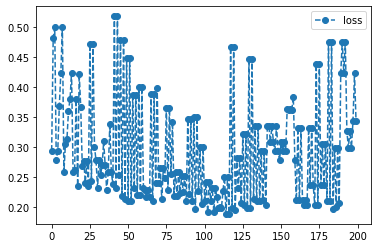

None


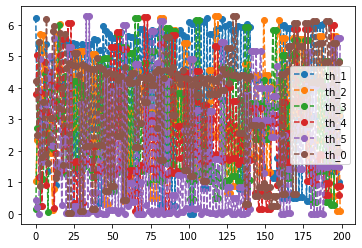

None


In [17]:
print("loss = ", test.energy)
print("method: ", mthd)
print("method parameters: ", mthd_opt)
print("execution time = ", (t1-t0)/60, " min")

print(test.history.plot('energies', label='loss'))
print(test.history.plot('angles', label=""))

### Test

Once trained, we have the optimal parameters for the classifier stored in `test.angles`. We run again the classifier with the test data set and with these parameters fixed.

In [18]:
test_set = 1000

# initialize
xval_test, yval_test, yval_rand, yval_real = [], [], [], []
suc = 0 # success
suc_rand = 0 # random success

for i in range(test_set):
    
    # random test point
    x = 2 * (np.random.rand(2)) - 1
    
    # state generated by the trained classifier
    qc = qcircuit(x, param)
    wfn_qc = tq.simulate(qc, variables=test.angles) 
        
    if nclass == 2:
        
        # compute the fidelity respect to one of the label states, the |0>
        f = abs(wfn_qc.inner(targ_wfn(0,nclass)))**2

        y = 1
        # if fidelity is >= 0.5, we conclude that this state belongs to |0> class
        # (|1> class otherwise)
        if f >= 0.5:
            y = 0
            
        # check the real class of the data point
        y_real = circle(random=False, x_input=x)
        
    else:
        raise Exception("nclass = {} is not considered".format(nclass))
    
    # compute success rate 
    if y == y_real:
        suc = suc + 1
        
    # compute random success rate 
    yrand = np.random.randint(0, nclass-1)
    if yrand == y_real:
        suc_rand = suc_rand + 1
        
    xval_test.append(x)
    yval_test.append(y)
    yval_real.append(y_real)
    
print("success %: ", 100*suc/test_set,"%")
print("random success %: ", 100*suc_rand/test_set,"%")

success %:  73.2 %
random success %:  47.9 %


Print results:

In [19]:
def plot_data(x, y, nclass, fig=None, ax=None):
    """
    Arg:
        - x (array[tuple]): data points
        - y (array[int]): data labels
        - nclass (int): number of classes
    Returns:
        - Plot
    """    
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
     
    # colors and labels
    col = ["red","blue","green","yellow"]
    lab = [0,1,2,3]
    
    for i in range(nclass):
        ax.scatter(x[y == lab[i], 0], x[y == lab[i], 1], c=col[i], s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

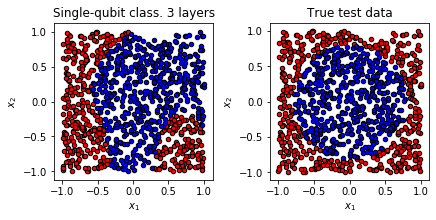

Total execution time:  56.456196109453835  min.


In [20]:
xval_test = np.array(xval_test)
yval_test = np.array(yval_test)
yval_real = np.array(yval_real)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

plot_data(xval_test, yval_test, nclass, fig, axes[0])
plot_data(xval_test, yval_real, nclass, fig, axes[1])

axes[0].set_title("Single-qubit class. {} layers".format(layers))
axes[1].set_title("True test data")
fig.tight_layout(pad=0.5)
plt.show()

t2 = time.time()
print("Total execution time: ", (t2-t0)/60," min.")

### Improvements and customization

This tutorial just shows a simple classification example. It is constructed in a way that one can easily change the classification model and try more sophisticated problems comprising more classes. To do so, one should define the target states for >2 classes, i.e. include more vectors in the Bloch sphere.

The single-qubit classifier circuit can also be modified to include higher dimensional data or to increase/reduce the number of parameters per layer.

The cost function can also be improved. See for instance the weigthed fidelity cost function proposed in the main reference.

Finally, the core of any variational algorithm is the minimization method. Tequila provides many methods besides the scipy ones. See the optimizers tutorial for more information.

One possibility to play with is to use Phoenics for initial exploration and a gradient based optimizer with the best phoenics results as starting point.